In [42]:
import os
import csv
import cv2
import numpy as np
import sklearn
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

data_dir = '{}/Desktop/local_test'.format(os.environ['HOME'])

training_set_file = '{}/training_set.csv'.format(data_dir) 
img_folder = '{}/IMG'.format(data_dir)
learning_rate = 0.01 # not used yet
epoch_num = 10
model_file = 'my_model.h5'

In [43]:
samples = []
with open(training_set_file) as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)


train_samples, validation_samples = train_test_split(samples, test_size=0.4)

In [44]:
print(len(train_samples))
print(len(validation_samples))

54
36


In [45]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        random.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = '{}/{}'.format(img_folder, batch_sample[0])
                image = cv2.imread(name)
                angle = float(batch_sample[1])
                images.append(image)
                angles.append(angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [46]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

Epoch 1/10


32/54 [================>.............] - ETA: 2s - loss: 0.3679

54/54 [==============================] - 5s - loss: 0.4991 - val_loss: 0.0739


Epoch 2/10


32/54 [================>.............] - ETA: 0s - loss: 0.5054

54/54 [==============================] - 2s - loss: 0.6568 - val_loss: 0.2295


Epoch 3/10


32/54 [================>.............] - ETA: 0s - loss: 0.5655

54/54 [==============================] - 2s - loss: 0.5127 - val_loss: 0.0781


Epoch 4/10


32/54 [================>.............] - ETA: 0s - loss: 0.2133

54/54 [==============================] - 2s - loss: 0.1693 - val_loss: 0.0610


Epoch 5/10


32/54 [================>.............] - ETA: 0s - loss: 0.2308

54/54 [==============================] - 2s - loss: 0.2394 - val_loss: 0.0645


Epoch 6/10


32/54 [================>.............] - ETA: 0s - loss: 0.2140

54/54 [==============================] - 2s - loss: 0.1631 - val_loss: 0.0720


Epoch 7/10


32/54 [================>.............] - ETA: 0s - loss: 0.0789

54/54 [==============================] - 2s - loss: 0.0946 - val_loss: 0.0810


Epoch 8/10


32/54 [================>.............] - ETA: 0s - loss: 0.1248

54/54 [==============================] - 2s - loss: 0.1130 - val_loss: 0.0938


Epoch 9/10


32/54 [================>.............] - ETA: 0s - loss: 0.0692

54/54 [==============================] - 2s - loss: 0.0873 - val_loss: 0.0991


Epoch 10/10


32/54 [================>.............] - ETA: 0s - loss: 0.0908

54/54 [==============================] - 2s - loss: 0.0937 - val_loss: 0.0897


dict_keys(['loss', 'val_loss'])


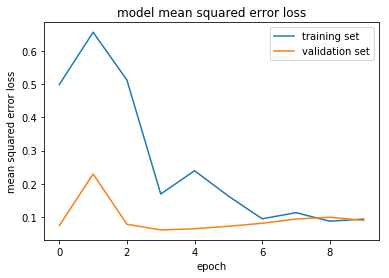

In [47]:
from keras.layers.normalization import BatchNormalization
from keras.layers import Cropping2D, Dropout, Lambda
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))

# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: x/127.5 - 1.))
model.add(BatchNormalization())

# Nvidia model
model.add(Convolution2D(24,5,5,border_mode='same'))
model.add(MaxPooling2D(pool_size=(5, 5)))
model.add(BatchNormalization())
model.add(Activation('elu'))

model.add(Convolution2D(36,5,5,border_mode='same'))
model.add(MaxPooling2D(pool_size=(5, 5)))
model.add(BatchNormalization())
model.add(Activation('elu'))

model.add(Convolution2D(48,3,3,border_mode='same'))
model.add(MaxPooling2D(pool_size=(3, 3), border_mode='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))

model.add(Convolution2D(64,3,3,border_mode='same'))
model.add(MaxPooling2D(pool_size=(3, 3), border_mode='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(1164))
model.add(Activation('elu'))

model.add(Dense(100))
model.add(Activation('elu'))

model.add(Dense(50))
model.add(Activation('elu'))

model.add(Dense(10))
model.add(Activation('elu'))

model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, 
                    samples_per_epoch= len(train_samples), 
                    validation_data=validation_generator,
                    nb_val_samples=len(validation_samples), 
                    nb_epoch=epoch_num, verbose=1)

print(history_object.history.keys())
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save(model_file)